# Quantitative Momentum Strategy

_**This notebook is a continuation of EW_SP500 notebook, which you should find in the very same folder as this notebook.**_

"Momentum investing" means investing in the stocks that have increased in price the most.

For this project, we're going to build an investing strategy that selects the 50 stocks with the highest price momentum. From there, we will calculate recommended trades for an equal-weight portfolio of these 50 stocks.


In [1]:
import numpy as np
import pandas as pd 
import requests 
import xlsxwriter 
import math 
from scipy import stats 

## Importing S&P 500 Stocks and API Calls

This part is essentially a copy-paste from the previous notebook, but in this case we are adding a new variable, which is the return of the stock in the last year (last 365 days). It must be said that the API provides with many other stats that can be used similarly, but in this case we will stick to this one because we are just trying to provide an example:

In [2]:
stocks = pd.read_csv('sp_500_stocks.csv')
from secrets import IEX_CLOUD_API_TOKEN

Now we divide the tickers in order to use batch calls:

In [3]:
def groups(lst,n):
    for i in range(0,len(lst),n):
        yield lst[i:i+n] #yield returns a generator
        
symbol_groups = list(groups(stocks['Ticker'], 100))
symbol_strings = []
for i in range(0, len(symbol_groups)):
    symbol_strings.append(','.join(symbol_groups[i]))

And now we select the data that is interesting for us and add it to a DataFrame:

In [4]:
my_columns = ['Ticker', 'Price', 'One-Year Price Return', 'Number of Shares to Buy']


final_dataframe = pd.DataFrame(columns = my_columns)

for symbol_string in symbol_strings:
#     print(symbol_strings)
    batch_api_call_url = f'https://sandbox.iexapis.com/stable/stock/market/batch/?types=stats,quote&symbols={symbol_string}&token={IEX_CLOUD_API_TOKEN}'
    data = requests.get(batch_api_call_url).json()
    for symbol in symbol_string.split(','):
        final_dataframe = final_dataframe.append(
                                        pd.Series([symbol, 
                                                   data[symbol]['quote']['latestPrice'],
                                                   data[symbol]['stats']['year1ChangePercent'], #stats is the endpoint, check documentation
                                                   'N/A'
                                                   ], 
                                                  index = my_columns), 
                                        ignore_index = True)
        
    
final_dataframe

,Ticker,Price,One-Year Price Return,Number of Shares to Buy
0,A,120.02,0.44948,N/A
1,AAL,17.43,-0.376494,N/A
2,AAP,159.02,0.0181535,N/A
3,AAPL,122.64,0.844804,N/A
4,ABBV,108.62,0.29743,N/A
...,...,...,...,...
500,YUM,107.07,0.0904064,N/A
501,ZBH,142.35,-0.0292246,N/A
502,ZBRA,382.73,0.49159,N/A
503,ZION,42.93,-0.138185,N/A


## Removing Low-Momentum Stock


Let's just stick to the 50 highest-momentum stock in the S&P 500.
In order to do this, we must sort the DataFrame:



In [5]:
final_dataframe = final_dataframe.sort_values("One-Year Price Return",ascending=False)
final_dataframe = final_dataframe[:51] #we only want the first 50
final_dataframe.reset_index(drop=True,inplace=True) #index reset

## Calculating the Number of Shares to Buy

Let's just define a function with the code we had in the previous notebook:

In [6]:
def number_shares_to_dataframe(dataframe):

    portfolio_size = input("Enter the value of your portfolio")

    try:
        val = float(portfolio_size)
    except ValueError:
        print("Please, enter a numerical value")
        portfolio_size = input("Enter the value of  your portfolio")
        val=float(portfolio_size)


    position_size = val/len(dataframe.index) #since we want EW portfolio, the size of each position is the same

    dataframe["Number of Shares to Buy"] =position_size/ dataframe["Price"] #we assume the name of the columns is that one

In [7]:
number_shares_to_dataframe(final_dataframe)

Enter the value of your portfolio 1000


In [8]:
final_dataframe

,Ticker,Price,One-Year Price Return,Number of Shares to Buy
0,CARR,37.71,2.11097,0.519964
1,NVDA,541.27,1.44832,0.036226
2,AMD,93.37,1.35439,0.210002
3,LB,41.01,1.32369,0.478123
4,ALB,142.38,1.21309,0.137715
5,PYPL,220.48,1.03482,0.088933
6,NOW,544.49,1.02817,0.036011
7,FCX,24.62,0.954811,0.796419
8,FDX,293.98,0.878357,0.066698
9,IDXX,476.40,0.860764,0.041158


## Building a more complex momentum strategy

We have to differentiate two different kinds of momentum stocks:

* High-quality momentum stocks show "slow and steady" outperformance over long periods of time
* Low-quality momentum stocks might not show any momentum for a long time, and then surge upwards.

High-quality momentum stocks are usually regarded as a better option because the other ones might be influence by short-term news that rarely happen, such as a merger.

In order to find high-quality momentum stocks, we can have a look not only at the yearly returns, but at some other returns in shorter periods of time. Fortunately, the API also provides this information. What we will do now is a copy of the code above, but with some extra columns:



In [12]:
hqm_columns = [
                'Ticker', 
                'Price', 
                'Number of Shares to Buy', 
                'One-Year Price Return', 
                'One-Year Return Percentile', #not known
                'Six-Month Price Return',
                'Six-Month Return Percentile', #not known
                'Three-Month Price Return',
                'Three-Month Return Percentile', #not known
                'One-Month Price Return',
                'One-Month Return Percentile', #not known
                'HQM Score'#not known
                ]





In [13]:
hqm_dataframe = pd.DataFrame(columns = hqm_columns)

for symbol_string in symbol_strings:
#     print(symbol_strings)
    batch_api_call_url = f'https://sandbox.iexapis.com/stable/stock/market/batch/?types=stats,quote&symbols={symbol_string}&token={IEX_CLOUD_API_TOKEN}'
    data = requests.get(batch_api_call_url).json()
    for symbol in symbol_string.split(','):
        hqm_dataframe = hqm_dataframe.append(
                                        pd.Series([symbol, 
                                                   data[symbol]['quote']['latestPrice'],
                                                   'N/A',
                                                   data[symbol]['stats']['year1ChangePercent'],
                                                   'N/A',
                                                   data[symbol]['stats']['month6ChangePercent'],
                                                   'N/A',
                                                   data[symbol]['stats']['month3ChangePercent'],
                                                   'N/A',
                                                   data[symbol]['stats']['month1ChangePercent'],
                                                   'N/A',
                                                   'N/A'
                                                   ], 
                                                  index = hqm_columns), 
                                        ignore_index = True)
        


In [14]:
hqm_dataframe 

,Ticker,Price,Number of Shares to Buy,One-Year Price Return,One-Year Return Percentile,Six-Month Price Return,Six-Month Return Percentile,Three-Month Price Return,Three-Month Return Percentile,One-Month Price Return,One-Month Return Percentile,HQM Score
0,A,120.41,N/A,0.446714,N/A,0.402519,N/A,0.213126,N/A,0.0851512,N/A,N/A
1,AAL,17.20,N/A,-0.368014,N/A,0.190447,N/A,0.318295,N/A,0.425492,N/A,N/A
2,AAP,165.40,N/A,0.0183316,N/A,0.195454,N/A,0.0219176,N/A,0.00745514,N/A,N/A
3,AAPL,128.17,N/A,0.831811,N/A,0.467657,N/A,0.0971679,N/A,0.0256463,N/A,N/A
4,ABBV,108.05,N/A,0.301037,N/A,0.185038,N/A,0.203793,N/A,0.0856928,N/A,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...
500,YUM,110.44,N/A,0.0877953,N/A,0.181228,N/A,0.158048,N/A,0.0466387,N/A,N/A
501,ZBH,147.44,N/A,-0.0288337,N/A,0.180922,N/A,0.0198738,N/A,-0.0524348,N/A,N/A
502,ZBRA,382.34,N/A,0.47173,N/A,0.53284,N/A,0.535587,N/A,0.0601344,N/A,N/A
503,ZION,41.87,N/A,-0.136479,N/A,0.272133,N/A,0.337516,N/A,0.121278,N/A,N/A


## Calculating Momentum Percentiles


We will not use the function that appears on the tutorial to calculate the percentil score. In this case, we will use the function `rank`, which is the one used when working with DataFrames




In [82]:
import matplotlib.pyplot as plt
for i in range(3,len(hqm_dataframe.columns)-1,2): #only columns of returns. This line would have to be adapted
         #if percentiles and returns are located differently
         percentiles = hqm_dataframe.iloc[:,i].rank(pct=True)
         hqm_dataframe.iloc[:,i+1] = percentiles #we add the value to the percentile columns 



Let's check that it makes sense by plotting one of the percentiles vs the returns:

<AxesSubplot:xlabel='Six-Month Return Percentile', ylabel='Six-Month Price Return'>

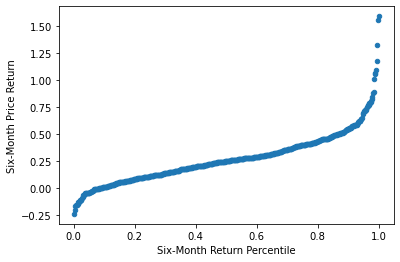

In [83]:
hqm_dataframe.plot.scatter(x='Six-Month Return Percentile', y='Six-Month Price Return')

## Calculating the HQM Score

In order to calculate the score, we will calculate the arithmetic mean of the 4 percentile scores, which is the simplest approach:

In [84]:
hqm_dataframe["HQM Score"] =   hqm_dataframe[['One-Year Return Percentile','Six-Month Return Percentile',
                                'Three-Month Return Percentile','One-Month Return Percentile']].mean(axis=1)

## Selecting Best Momentum Stocks

Again, we choose the 50 stocks with the best HQM:

In [91]:
best_hqm_dataframe = hqm_dataframe.sort_values("HQM Score",ascending=False)
best_hqm_dataframe = best_hqm_dataframe[:51] #we only want the first 50
best_hqm_dataframe.reset_index(drop=True,inplace=True) #index reset

In [92]:
best_hqm_dataframe

,Ticker,Price,Number of Shares to Buy,One-Year Price Return,One-Year Return Percentile,Six-Month Price Return,Six-Month Return Percentile,Three-Month Price Return,Three-Month Return Percentile,One-Month Price Return,One-Month Return Percentile,HQM Score
0,FCX,25.03,N/A,0.958189,0.986028,1.54885,0.998004,0.53268,0.960080,0.265373,0.944112,0.972056
1,ALB,142.65,N/A,1.17666,0.992016,0.886927,0.984032,0.475617,0.950100,0.174153,0.876248,0.950599
2,LRCX,492.10,N/A,0.853269,0.980040,0.760609,0.964072,0.700818,0.984032,0.166813,0.870259,0.949601
3,LB,41.41,N/A,1.31923,0.994012,1.58696,1.000000,0.423628,0.932136,0.162043,0.862275,0.947106
4,AMAT,88.50,N/A,0.537483,0.924152,0.618098,0.938124,0.614019,0.976048,0.248099,0.928144,0.941617
5,ALGN,515.05,N/A,0.861616,0.984032,1.17084,0.994012,0.611989,0.974052,0.0983759,0.738523,0.922655
6,XLNX,146.33,N/A,0.582046,0.936128,0.642278,0.944112,0.46592,0.948104,0.133034,0.816367,0.911178
7,URI,249.68,N/A,0.553808,0.926148,0.69704,0.950100,0.386986,0.898204,0.164689,0.864271,0.909681
8,TWTR,53.87,N/A,0.683804,0.956088,0.582135,0.920160,0.33715,0.864271,0.187289,0.890220,0.907685
9,MU,71.43,N/A,0.442499,0.882236,0.461689,0.836327,0.544475,0.966068,0.262445,0.934132,0.904691


## Calculating Number of Shares to Buy

In [99]:
number_shares_to_dataframe(best_hqm_dataframe)

Enter the value of your portfolio 1000


In [106]:
best_hqm_dataframe

,Ticker,Price,Number of Shares to Buy,One-Year Price Return,One-Year Return Percentile,Six-Month Price Return,Six-Month Return Percentile,Three-Month Price Return,Three-Month Return Percentile,One-Month Price Return,One-Month Return Percentile,HQM Score
0,FCX,25.03,0.783374,0.958189,0.986028,1.54885,0.998004,0.53268,0.960080,0.265373,0.944112,0.972056
1,ALB,142.65,0.137454,1.17666,0.992016,0.886927,0.984032,0.475617,0.950100,0.174153,0.876248,0.950599
2,LRCX,492.10,0.039845,0.853269,0.980040,0.760609,0.964072,0.700818,0.984032,0.166813,0.870259,0.949601
3,LB,41.41,0.473505,1.31923,0.994012,1.58696,1.000000,0.423628,0.932136,0.162043,0.862275,0.947106
4,AMAT,88.50,0.221558,0.537483,0.924152,0.618098,0.938124,0.614019,0.976048,0.248099,0.928144,0.941617
5,ALGN,515.05,0.038070,0.861616,0.984032,1.17084,0.994012,0.611989,0.974052,0.0983759,0.738523,0.922655
6,XLNX,146.33,0.133997,0.582046,0.936128,0.642278,0.944112,0.46592,0.948104,0.133034,0.816367,0.911178
7,URI,249.68,0.078532,0.553808,0.926148,0.69704,0.950100,0.386986,0.898204,0.164689,0.864271,0.909681
8,TWTR,53.87,0.363984,0.683804,0.956088,0.582135,0.920160,0.33715,0.864271,0.187289,0.890220,0.907685
9,MU,71.43,0.274504,0.442499,0.882236,0.461689,0.836327,0.544475,0.966068,0.262445,0.934132,0.904691


## Obtaining the .xlsx File

Same procedure we have seen in the first notebook, but with different columns.

In [122]:
writer = pd.ExcelWriter('recommended_trades_momentum.xlsx', engine='xlsxwriter')
best_hqm_dataframe.to_excel(writer, sheet_name='Momentum Strategy', index = False)

In [123]:
background_color = '#0a0a23'
font_color = '#ffffff'

string_format = writer.book.add_format(
        {
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

dollar_format = writer.book.add_format(
        {
            'num_format':'$0.00',
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

integer_format = writer.book.add_format(
        {
            'num_format':'0',
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

float_format = writer.book.add_format(   #new addition
        {
            'num_format':'0.00',
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

In [124]:
column_formats = { 
                    'A': ['Ticker', string_format],
                    'B': ['Price', dollar_format],
                    'C': ['Number of Shares to Buy', float_format],
                    'D': ['One-Year Price Return', float_format],
                    'E': ['One-Year Return Percentile', float_format],
                    'F': ['Six-Month Price Return', float_format],
                    'G': ['Six-Month Return Percentile', float_format],
                    'H': ['Three-Month Price Return', float_format],
                    'I': ['Three-Month Return Percentile', float_format],
                    'J': ['One-Month Price Return', float_format],
                    'K': ['One-Month Return Percentile', float_format],
                    'L': ['HQM Score',float_format]
                    }

for column in column_formats.keys():
    writer.sheets['Momentum Strategy'].set_column(f'{column}:{column}', 20, column_formats[column][1])
    writer.sheets['Momentum Strategy'].write(f'{column}1', column_formats[column][0], string_format)

In [125]:
writer.save()

## References

Algorithmic Trading Using Python - Full Course : https://www.youtube.com/watch?v=xfzGZB4HhEE&t=14236s